In [1]:
# debugging and formatter
from IPython.core.debugger import set_trace

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
import time
import lightgbm as lgb
import xgboost as xgb

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
from os import listdir
from os.path import isfile, join

loc = os.path.abspath("")
data_loc = f"{loc}/data"

<IPython.core.display.Javascript object>

Check data loading time and memory usage...

In [11]:
%%time
train_id = pd.read_parquet(f"{data_loc}/train_identity.parquet.gzip")
train_tr = pd.read_parquet(f"{data_loc}/train_transaction.parquet.gzip")
test_id = pd.read_parquet(f"{data_loc}/test_identity.parquet.gzip")
test_tr = pd.read_parquet(f"{data_loc}/test_transaction.parquet.gzip")

CPU times: user 8.53 s, sys: 4.91 s, total: 13.4 s
Wall time: 1.51 s


<IPython.core.display.Javascript object>

In [24]:
train = pd.merge(
    train_tr,
    train_id,
    how="left",
    on="TransactionID",
    left_index=True,
    right_index=True,
)

<IPython.core.display.Javascript object>

In [25]:
test = pd.merge(
    test_tr, test_id, how="left", on="TransactionID", left_index=True, right_index=True
)

<IPython.core.display.Javascript object>

In [26]:
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (590540, 434), Test shape: (506691, 433)


<IPython.core.display.Javascript object>

In [27]:
imp_features = [
    "TransactionAmt",
    "ProductCD",
    "card1",
    "card2",
    "card3",
    "card5",
    "card6",
    "addr1",
    "addr2",
    "dist1",
    "dist2",
    "P_emaildomain",
    "R_emaildomain",
    "C1",
    "C2",
    "C4",
    "C5",
    "C6",
    "C7",
    "C8",
    "C9",
    "C10",
    "C11",
    "C12",
    "C13",
    "C14",
    "D1",
    "D2",
    "D3",
    "D4",
    "D5",
    "D10",
    "D11",
    "D15",
    "M1",
    "M2",
    "M3",
    "M4",
    "M6",
    "M7",
    "M8",
    "M9",
    "V1",
    "V3",
    "V4",
    "V6",
    "V8",
    "V11",
    "V13",
    "V14",
    "V17",
    "V20",
    "V23",
    "V26",
    "V27",
    "V30",
    "V36",
    "V37",
    "V40",
    "V41",
    "V44",
    "V47",
    "V48",
    "V54",
    "V56",
    "V59",
    "V62",
    "V65",
    "V67",
    "V68",
    "V70",
    "V76",
    "V78",
    "V80",
    "V82",
    "V86",
    "V88",
    "V89",
    "V91",
    "V107",
    "V108",
    "V111",
    "V115",
    "V117",
    "V120",
    "V121",
    "V123",
    "V124",
    "V127",
    "V129",
    "V130",
    "V136",
    "V138",
    "V139",
    "V142",
    "V147",
    "V156",
    "V160",
    "V162",
    "V165",
    "V166",
    "V169",
    "V171",
    "V173",
    "V175",
    "V176",
    "V178",
    "V180",
    "V182",
    "V185",
    "V187",
    "V188",
    "V198",
    "V203",
    "V205",
    "V207",
    "V209",
    "V210",
    "V215",
    "V218",
    "V220",
    "V221",
    "V223",
    "V224",
    "V226",
    "V228",
    "V229",
    "V234",
    "V235",
    "V238",
    "V240",
    "V250",
    "V252",
    "V253",
    "V257",
    "V258",
    "V260",
    "V261",
    "V264",
    "V266",
    "V267",
    "V271",
    "V274",
    "V277",
    "V281",
    "V283",
    "V284",
    "V285",
    "V286",
    "V289",
    "V291",
    "V294",
    "V296",
    "V297",
    "V301",
    "V303",
    "V305",
    "V307",
    "V309",
    "V310",
    "V314",
    "V320",
    "DeviceType",
    "DeviceInfo",
    "isFraud",
]

<IPython.core.display.Javascript object>

In [28]:
len(imp_features)

165

<IPython.core.display.Javascript object>

In [29]:
cols_to_drop_train = [col for col in train.columns if col not in imp_features]
cols_to_drop_test = [col for col in test.columns if col not in imp_features]

print(f"{len(cols_to_drop_train)} features from train are going to be dropped.")
print(f"{len(cols_to_drop_test)} features from test are going to be dropped.")

269 features from train are going to be dropped.
269 features from test are going to be dropped.


<IPython.core.display.Javascript object>

In [30]:
train = train.drop(cols_to_drop_train, axis=1)
test = test.drop(cols_to_drop_test, axis=1)

<IPython.core.display.Javascript object>

In [31]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)

<IPython.core.display.Javascript object>

In [32]:
train = clean_inf_nan(train)
test = clean_inf_nan(test)

<IPython.core.display.Javascript object>

In [33]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [34]:
for col in train.columns:
    if train[col].dtype == "object":
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

<IPython.core.display.Javascript object>

In [35]:
print(train.shape)
print(test.shape)

(590540, 165)
(506691, 164)


<IPython.core.display.Javascript object>

In [36]:
X_train = train.drop("isFraud", axis=1).copy()
X_test = test.copy()
y_train = train["isFraud"].copy()

<IPython.core.display.Javascript object>

In [37]:
print(X_train.shape, X_test.shape, y_train.shape)

(590540, 164) (506691, 164) (590540,)


<IPython.core.display.Javascript object>

In [38]:
from sklearn.model_selection import train_test_split

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.3, random_state=7
)

<IPython.core.display.Javascript object>

### Simple RandomForest model

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    max_depth=45, max_features=30, n_estimators=500, n_jobs=-1, min_samples_leaf=200
)

<IPython.core.display.Javascript object>

In [40]:
%%time 
rf.fit(X_train_split, y_train_split)

CPU times: user 1h 38min, sys: 41.4 s, total: 1h 38min 42s
Wall time: 7min 9s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=45, max_features=30,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

<IPython.core.display.Javascript object>

In [41]:
print("Roc Auc Score:", roc_auc_score(y_test_split, rf.predict(X_test_split)))

Roc Auc Score: 0.6145066222628707


<IPython.core.display.Javascript object>

The most important 20 features

In [66]:
feats = {}
for feature, importance in zip(X_train.columns, rf.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient="index").rename(
    columns={0: "Gini-importance"}
)
imp = importances.sort_values(by="Gini-importance", ascending=False)[:20]

<IPython.core.display.Javascript object>

Index(['V258', 'V257', 'C1', 'V187', 'V188', 'C13', 'C12', 'C7', 'C14', 'V44',
       'V274', 'V294', 'C11', 'C4', 'V283', 'V156', 'V86', 'C8',
       'TransactionAmt', 'C10'],
      dtype='object')


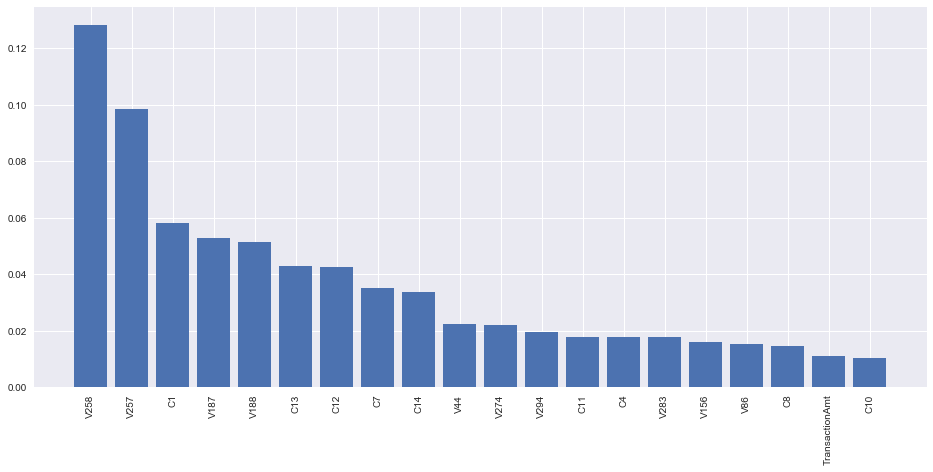

<IPython.core.display.Javascript object>

In [67]:
plt.figure(1, figsize=(16, 7))
plt.bar(imp.index, imp["Gini-importance"])
plt.xticks(imp.index, rotation=90)
print(imp.index)

In [44]:
from sklearn.model_selection import TimeSeriesSplit, KFold

n_folds = 5
folds = TimeSeriesSplit(n_splits=n_folds)
folds = KFold(n_splits=5)

<IPython.core.display.Javascript object>

### LightGBM model 

In [45]:
columns = X_train.columns

splits = folds.split(X_train, y_train)

y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])

score_auc = 0

feature_importances = pd.DataFrame()
feature_importances["feature"] = columns

<IPython.core.display.Javascript object>

In [46]:
params = {
    "num_leaves": 64,
    "min_child_weight": 0.03,
    "feature_fraction": 0.04,
    "bagging_fraction": 0.33,
    "min_data_in_leaf": 80,
    "objective": "binary",
    "max_depth": -1,
    "learning_rate": 0.006,
    "boosting_type": "gbdt",
    "bagging_seed": 7,
    "metric": "auc",
    "verbosity": -1,
    "reg_alpha": 0.3,
    "reg_lambda": 0.6,
    "random_state": 0,
}

<IPython.core.display.Javascript object>

In [47]:
%%time
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_tr, X_val = X_train[columns].iloc[train_index], X_train[columns].iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dvalid = lgb.Dataset(X_val, label=y_val)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=100)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_val = clf.predict(X_val)
    y_oof[valid_index] = y_pred_val
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_val, y_pred_val)}")
    
    score_auc += roc_auc_score(y_val, y_pred_val) / n_folds
    
    y_preds += clf.predict(X_test) / n_folds
    
    del X_tr, X_val, y_tr, y_val

Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.86939	valid_1's auc: 0.794552
[400]	training's auc: 0.882176	valid_1's auc: 0.815951
[600]	training's auc: 0.891082	valid_1's auc: 0.83081
[800]	training's auc: 0.898997	valid_1's auc: 0.843218
[1000]	training's auc: 0.90553	valid_1's auc: 0.851813
[1200]	training's auc: 0.911652	valid_1's auc: 0.859784
[1400]	training's auc: 0.916559	valid_1's auc: 0.865761
[1600]	training's auc: 0.92092	valid_1's auc: 0.870531
[1800]	training's auc: 0.924349	valid_1's auc: 0.874235
[2000]	training's auc: 0.927669	valid_1's auc: 0.877714
[2200]	training's auc: 0.930528	valid_1's auc: 0.880527
[2400]	training's auc: 0.933126	valid_1's auc: 0.883205
[2600]	training's auc: 0.935623	valid_1's auc: 0.885703
[2800]	training's auc: 0.938245	valid_1's auc: 0.887958
[3000]	training's auc: 0.940484	valid_1's auc: 0.889852
[3200]	training's auc: 0.942283	valid_1's auc: 0.891406
[3400]	training's auc: 0.944271	valid_1's auc: 0.8

[1600]	training's auc: 0.917472	valid_1's auc: 0.905852
[1800]	training's auc: 0.920959	valid_1's auc: 0.907835
[2000]	training's auc: 0.924359	valid_1's auc: 0.909971
[2200]	training's auc: 0.927178	valid_1's auc: 0.911664
[2400]	training's auc: 0.929916	valid_1's auc: 0.913231
[2600]	training's auc: 0.93254	valid_1's auc: 0.914824
[2800]	training's auc: 0.935152	valid_1's auc: 0.916512
[3000]	training's auc: 0.937448	valid_1's auc: 0.917927
[3200]	training's auc: 0.939328	valid_1's auc: 0.918946
[3400]	training's auc: 0.941323	valid_1's auc: 0.920121
[3600]	training's auc: 0.943133	valid_1's auc: 0.921062
[3800]	training's auc: 0.944771	valid_1's auc: 0.921965
[4000]	training's auc: 0.946419	valid_1's auc: 0.922864
[4200]	training's auc: 0.947933	valid_1's auc: 0.923585
[4400]	training's auc: 0.949262	valid_1's auc: 0.924195
[4600]	training's auc: 0.950571	valid_1's auc: 0.924798
[4800]	training's auc: 0.951822	valid_1's auc: 0.925286
[5000]	training's auc: 0.953053	valid_1's auc: 0.

<IPython.core.display.Javascript object>

In [48]:
print(f"\nMean AUC = {score_auc}")
print(f"Out of folds AUC = {roc_auc_score(y_train, y_oof)}")


Mean AUC = 0.9133312155307719
Out of folds AUC = 0.9142822832932855


<IPython.core.display.Javascript object>

In [49]:
feature_importances["average"] = feature_importances[
    ["fold_{}".format(fold + 1) for fold in range(folds.n_splits)]
].mean(axis=1)

<IPython.core.display.Javascript object>

In [58]:
f = (
    feature_importances[["feature", "average"]]
    .sort_values(by="average", ascending=False)
    .head(20)
)

<IPython.core.display.Javascript object>

Index(['V257', 'V253', 'R_emaildomain', 'V185', 'V187', 'C12', 'C11', 'C6',
       'C13', 'V41', 'V271', 'V291', 'C10', 'C2', 'V281', 'V147', 'V82', 'C7',
       'isFraud', 'C9'],
      dtype='object')


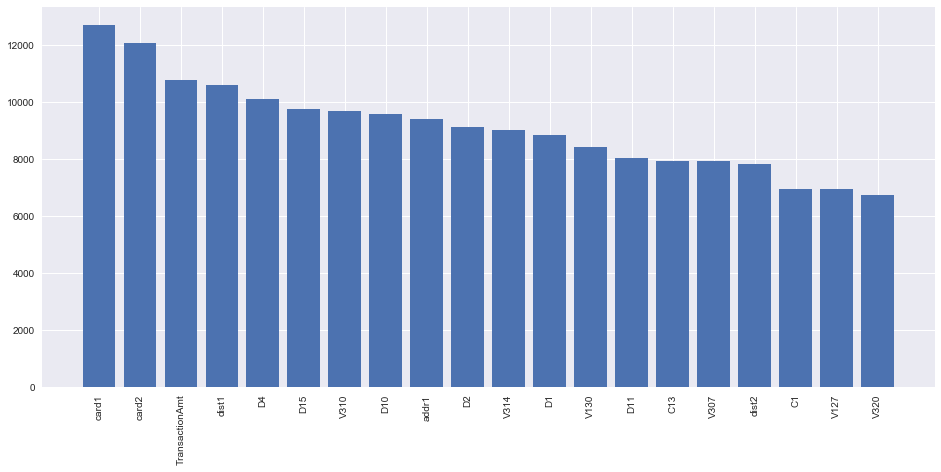

<IPython.core.display.Javascript object>

In [59]:
plt.figure(1, figsize=(16, 7))
plt.bar(f["feature"], f["average"])
plt.xticks(f["feature"], rotation=90)
print(imp.index)

In [75]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.006,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.03,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 64,
 'objective': 'binary',
 'random_state': 0,
 'reg_alpha': 0.3,
 'reg_lambda': 0.6,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'feature_fraction': 0.04,
 'bagging_fraction': 0.33,
 'min_data_in_leaf': 80,
 'bagging_seed': 7,
 'metric': 'auc',
 'verbosity': -1,
 'num_boost_round': 5575}

<IPython.core.display.Javascript object>

In [76]:
final_clf = lgb.LGBMClassifier(**clf.get_params())

<IPython.core.display.Javascript object>

In [77]:
final_clf.fit(X_train, y_train)

/Users/radufotolescu/.local/share/virtualenvs/fraud-detection-5KZQpUEG/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.33, bagging_seed=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.04,
               importance_type='split', learning_rate=0.006, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.03,
               min_data_in_leaf=80, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=5575, num_leaves=64,
               objective='binary', random_state=0, reg_alpha=0.3,
               reg_lambda=0.6, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

<IPython.core.display.Javascript object>

In [84]:
sub = pd.read_csv(f"{data_loc}/sample_submission.csv")

<IPython.core.display.Javascript object>

In [85]:
sub

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5
...,...,...
506686,4170235,0.5
506687,4170236,0.5
506688,4170237,0.5
506689,4170238,0.5


<IPython.core.display.Javascript object>

In [86]:
sub["Fraud"] = final_clf.predict_proba(X_test)[:, 1]

<IPython.core.display.Javascript object>

In [87]:
sub

,TransactionID,isFraud,Fraud
0,3663549,0.5,0.005698
1,3663550,0.5,0.005601
2,3663551,0.5,0.008493
3,3663552,0.5,0.002523
4,3663553,0.5,0.005884
...,...,...,...
506686,4170235,0.5,0.019034
506687,4170236,0.5,0.023178
506688,4170237,0.5,0.010847
506689,4170238,0.5,0.008784


<IPython.core.display.Javascript object>

Final Public Score: 0.923136